In [25]:
!pip install matplotlib
!pip install seaborn
!pip install plotly

In [45]:
import os
import sys

path_to_research = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

if path_to_research not in sys.path:
    sys.path.insert(0, path_to_research)

print(f"sys.path: {path_to_research}")

sys.path: /home/emanu/ubuntu/ita/HardnessMDL/research


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from typing import Any, Dict, List
from joblib import Parallel, delayed

import hardnessmdl


In [28]:
df1 = pd.read_csv('test1.csv')
df2 = pd.read_csv('test2.csv')
df3 = pd.read_csv('test3.csv')
df4 = pd.read_csv('test4.csv')

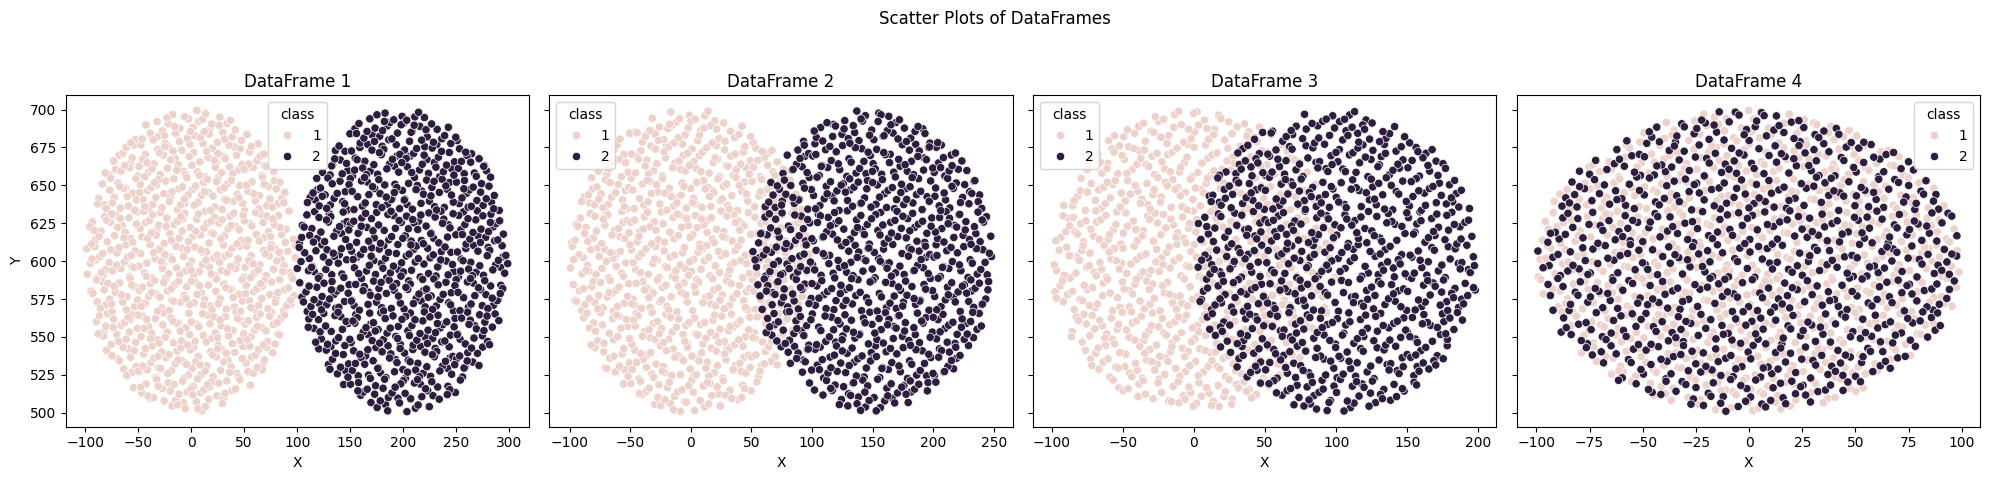

In [29]:

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.suptitle('Scatter Plots of DataFrames')

sns.scatterplot(ax=axes[0], data=df1, x='X', y='Y', hue='class')
axes[0].set_title('DataFrame 1')

sns.scatterplot(ax=axes[1], data=df2, x='X', y='Y', hue='class')
axes[1].set_title('DataFrame 2')

sns.scatterplot(ax=axes[2], data=df3, x='X', y='Y', hue='class')
axes[2].set_title('DataFrame 3')

sns.scatterplot(ax=axes[3], data=df4, x='X', y='Y', hue='class')
axes[3].set_title('DataFrame 4')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
def _compute_single(
    test_index: int,
    df: pd.DataFrame,
    feature_cols: List[str],
    label_col: str,
    class_map: Dict[str, int],
    n_classes: int,
    n_dims: int,
    kwargs: Dict[str, Any],
):
    """Auxiliary function"""
    test_df = df.loc[[test_index]]
    train_df = df.drop(index=test_index)

    model = hardnessmdl.HardnessMDL(n_classes=n_classes, n_dims=n_dims)

    model.set_learning_rate(kwargs.get("learning_rate", 0.01))
    model.set_momentum(kwargs.get("momentum", 0.9))
    model.set_tau(kwargs.get("tau", 0))
    model.set_omega(kwargs.get("omega", 32.0))
    model.set_forgetting_factor(kwargs.get("forgetting_factor", 1.0))
    model.set_sigma(kwargs.get("sigma", 1.0))

    X_train = train_df[feature_cols].to_numpy()
    y_train_names = train_df[label_col].to_numpy()

    X_test = test_df[feature_cols].to_numpy()
    y_test_name = test_df[label_col].to_numpy()[0]
    true_label = class_map[y_test_name]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    
    for j in range(len(X_train_scaled)):
        features = X_train_scaled[j]
        label = class_map[y_train_names[j]]
        model.train(features, label)

    hardness_dict = model.hardness(X_test_scaled[0], true_label)

    feature_dict = {col: val for col, val in zip(feature_cols, X_test[0])}

    return {
        "index": test_index,
        **feature_dict,
        **hardness_dict,
    }


def compute_loo_hardness(
    df: pd.DataFrame,
    feature_cols: List[str],
    label_col: str,
    n_jobs: int = os.cpu_count() // 2,
    **kwargs: Dict[str, Any],
) -> List[Any]:
    """
    Parallel Leave-One-Out hardness computation using joblib + tqdm.
    Computes hardness measures for each sample in a dataframe using
    Leave-One-Out cross-validation.

    Args:
        df: The full dataframe containing all samples.
        feature_cols: A list of column names to be used as features.
        label_col: The name of the column containing the class label.
        **kwargs: Hyperparameters for the GMDL model.

    Returns:
        A list of hardness measures, one for each sample in the original dataframe.
    """
    class_names = sorted(df[label_col].unique().tolist())
    class_map = {name: i for i, name in enumerate(class_names)}
    n_classes = len(class_names)
    n_dims = len(feature_cols)

    results = Parallel(n_jobs=n_jobs, batch_size="auto")(
        delayed(_compute_single)(
            test_index,
            df,
            feature_cols,
            label_col,
            class_map,
            n_classes,
            n_dims,
            kwargs,
        )
        for test_index in df.index
    )

    return results



In [32]:
feature_columns = ['X', 'Y']
label_column = 'class'

In [33]:
measures1 = compute_loo_hardness(df1, feature_columns, label_column)
df1_result = pd.DataFrame(measures1)
df1_result.to_csv("output_1.csv", index=False)

In [34]:
measures2 = compute_loo_hardness(df2, feature_columns, label_column)
df2_result = pd.DataFrame(measures2)
df2_result.to_csv("output_2.csv", index=False)

In [35]:
measures3 = compute_loo_hardness(df3, feature_columns, label_column)
df3_result = pd.DataFrame(measures3)
df3_result.to_csv("output_3.csv", index=False)

In [36]:
measures4 = compute_loo_hardness(df4, feature_columns, label_column)
df4_result = pd.DataFrame(measures4)
df4_result.to_csv("output_4.csv", index=False)

In [37]:
df1_result.describe()

,index,X,Y,label,true_label,r_min,r_med,relative_position,pseudo_probability,normalized_entropy
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,749.500000,99.702942,600.057473,0.498000,0.500000,0.323620,0.323620,0.002000,0.408858,0.321391
std,433.157015,111.620661,50.010578,0.500163,0.500167,0.175271,0.175271,0.044692,0.029278,0.015998
min,0.000000,-98.615405,500.678997,0.000000,0.000000,0.156418,0.156418,0.000000,0.376217,0.299012
25%,374.750000,0.041822,559.805431,0.000000,0.000000,0.195219,0.195219,0.000000,0.385393,0.307165
50%,749.500000,99.494674,600.046831,0.000000,0.500000,0.258594,0.258594,0.000000,0.399316,0.318131
75%,1124.250000,199.142838,640.636246,1.000000,1.000000,0.392030,0.392030,0.000000,0.424890,0.334149
max,1499.000000,298.776627,699.465469,1.000000,1.000000,1.000000,1.000000,1.000000,0.513428,0.353553


In [38]:
df2_result.describe()

,index,X,Y,label,true_label,r_min,r_med,relative_position,pseudo_probability,normalized_entropy
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,749.500000,75.312967,599.887778,0.526667,0.500000,0.474996,0.474996,0.069333,0.435340,0.334895
std,433.157015,90.646846,49.941633,0.499455,0.500167,0.225586,0.225586,0.254105,0.034731,0.012202
min,0.000000,-99.337232,500.851619,0.000000,0.000000,0.243767,0.243767,0.000000,0.396171,0.315798
25%,374.750000,-0.216138,559.448941,0.000000,0.000000,0.298662,0.298662,0.000000,0.407495,0.323819
50%,749.500000,75.532954,599.990072,1.000000,0.500000,0.393831,0.393831,0.000000,0.425204,0.334314
75%,1124.250000,150.549624,640.429593,1.000000,1.000000,0.587790,0.587790,0.000000,0.455134,0.346572
max,1499.000000,248.157046,699.026915,1.000000,1.000000,1.000000,1.000000,1.000000,0.551851,0.353553


In [39]:
df3_result.describe()

,index,X,Y,label,true_label,r_min,r_med,relative_position,pseudo_probability,normalized_entropy
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,749.500000,50.017162,599.856500,0.529333,0.500000,0.631579,0.631579,0.138667,0.459320,0.344447
std,433.157015,70.714173,50.120056,0.499305,0.500167,0.223634,0.223634,0.345714,0.031676,0.007721
min,0.000000,-98.145298,501.109746,0.000000,0.000000,0.260207,0.260207,0.000000,0.399654,0.318377
25%,374.750000,-0.147251,559.345337,0.000000,0.000000,0.442731,0.442731,0.000000,0.433463,0.338390
50%,749.500000,49.709740,599.752004,1.000000,0.500000,0.559707,0.559707,0.000000,0.451238,0.345467
75%,1124.250000,99.945149,640.431158,1.000000,1.000000,0.827760,0.827760,0.000000,0.483676,0.352065
max,1499.000000,197.711262,698.851510,1.000000,1.000000,1.000000,1.000000,1.000000,0.547655,0.353553


In [40]:
df4_result.describe()

,index,X,Y,label,true_label,r_min,r_med,relative_position,pseudo_probability,normalized_entropy
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,749.500000,0.060013,599.782795,0.491333,0.500000,0.997722,0.997722,0.575333,0.501765,0.353455
std,433.157015,49.931254,49.766294,0.500092,0.500167,0.003253,0.003253,0.494457,0.005103,0.000308
min,0.000000,-99.259220,500.959431,0.000000,0.000000,0.989993,0.989993,0.000000,0.499129,0.351583
25%,374.750000,-39.743651,559.706845,0.000000,0.000000,0.995306,0.995306,0.000000,0.499592,0.353551
50%,749.500000,0.077656,599.994775,0.000000,0.500000,1.000000,1.000000,1.000000,0.500184,0.353552
75%,1124.250000,40.096437,639.617478,1.000000,1.000000,1.000000,1.000000,1.000000,0.500816,0.353553
max,1499.000000,98.657697,699.395917,1.000000,1.000000,1.000000,1.000000,1.000000,0.524143,0.353553


In [41]:
abs(df1_result.label - df1_result.true_label).sum()

np.int64(3)

In [42]:
dfs = [df1_result, df2_result, df3_result, df4_result]

df_meta_feats_dict = {}

for i, df in enumerate(dfs):
    df_meta_feats_dict[f'DataFrame {i+1}'] = df

In [48]:
!pip install nbformat

In [49]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=4, subplot_titles=(
    "DataFrame 1",
    "DataFrame 2",
    "DataFrame 3",
    "DataFrame 4"
))

for i, df in enumerate(dfs):
    df_name = f'DataFrame {i+1}'
    dcp_values = df_meta_feats_dict[df_name]['r_min']

    fig.add_trace(go.Scattergl(x=df["X"], y=df["Y"], mode='markers',
                             marker=dict(color=dcp_values,
                                         colorscale='viridis',
                                         cmin=0, cmax=1, 
                                         showscale=True if i == 3 else False, 
                                         colorbar=dict(title='r_min', x=1.02)),
                             name=df_name),
                  row=1, col=i+1)

fig.update_layout(title_text="Scatter Plots of DataFrames 1 to 4", showlegend=False)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
fig = make_subplots(rows=1, cols=4, subplot_titles=(
    "DataFrame 1",
    "DataFrame 2",
    "DataFrame 3",
    "DataFrame 4"
))

for i, df in enumerate(dfs):
    df_name = f'DataFrame {i+1}'
    dcp_values = df_meta_feats_dict[df_name]['r_med']

    fig.add_trace(go.Scattergl(x=df["X"], y=df["Y"], mode='markers',
                             marker=dict(color=dcp_values,
                                         colorscale='viridis',
                                         cmin=0, cmax=1, 
                                         showscale=True if i == 3 else False, 
                                         colorbar=dict(title='r_med', x=1.02)),
                             name=df_name),
                  row=1, col=i+1)

fig.update_layout(title_text="Scatter Plots of DataFrames 1 to 4", showlegend=False)
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=4, subplot_titles=(
    "DataFrame 1",
    "DataFrame 2",
    "DataFrame 3",
    "DataFrame 4"
))

for i, df in enumerate(dfs):
    df_name = f'DataFrame {i+1}'
    dcp_values = df_meta_feats_dict[df_name]['relative_position']

    fig.add_trace(go.Scattergl(x=df["X"], y=df["Y"], mode='markers',
                             marker=dict(color=dcp_values,
                                         colorscale='viridis',
                                         cmin=0, cmax=1, 
                                         showscale=True if i == 3 else False, 
                                         colorbar=dict(title='relative_position', x=1.02)),
                             name=df_name),
                  row=1, col=i+1)

fig.update_layout(title_text="Scatter Plots of DataFrames 1 to 4", showlegend=False)
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=4, subplot_titles=(
    "DataFrame 1",
    "DataFrame 2",
    "DataFrame 3",
    "DataFrame 4"
))

for i, df in enumerate(dfs):
    df_name = f'DataFrame {i+1}'
    dcp_values = df_meta_feats_dict[df_name]['pseudo_probability']

    fig.add_trace(go.Scattergl(x=df["X"], y=df["Y"], mode='markers',
                             marker=dict(color=dcp_values,
                                         colorscale='viridis',
                                         cmin=0, cmax=1, 
                                         showscale=True if i == 3 else False, 
                                         colorbar=dict(title='pseudo_probability', x=1.02)),
                             name=df_name),
                  row=1, col=i+1)

fig.update_layout(title_text="Scatter Plots of DataFrames 1 to 4", showlegend=False)
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=4, subplot_titles=(
    "DataFrame 1",
    "DataFrame 2",
    "DataFrame 3",
    "DataFrame 4"
))

for i, df in enumerate(dfs):
    df_name = f'DataFrame {i+1}'
    dcp_values = df_meta_feats_dict[df_name]['normalized_entropy']

    fig.add_trace(go.Scattergl(x=df["X"], y=df["Y"], mode='markers',
                             marker=dict(color=dcp_values,
                                         colorscale='viridis',
                                         cmin=0, cmax=1, 
                                         showscale=True if i == 3 else False, 
                                         colorbar=dict(title='normalized_entropy', x=1.02)),
                             name=df_name),
                  row=1, col=i+1)

fig.update_layout(title_text="Scatter Plots of DataFrames 1 to 4", showlegend=False)
fig.show()

In [ ]:
pd.read_csv("output_1.csv")

,index,X,Y,label,true_label,r_min,r_med,relative_position,pseudo_probability,normalized_entropy
0,0,-82.795092,590.955588,1,0,1,1,1.0,0.504067,0.353498
1,1,17.204908,516.881513,1,0,1,1,1.0,0.507910,0.353342
2,2,-32.795092,650.214847,1,0,1,1,1.0,0.506308,0.353419
3,3,67.204908,583.548180,1,0,1,1,1.0,0.510192,0.353203
4,4,-57.795092,561.325958,1,0,1,1,1.0,0.505208,0.353462
...,...,...,...,...,...,...,...,...,...,...
1495,1495,202.682877,582.709176,0,1,1,1,1.0,0.507721,0.353352
1496,1496,152.682877,560.486953,0,1,1,1,1.0,0.509440,0.353253
1497,1497,127.682877,627.153620,0,1,1,1,1.0,0.510257,0.353198
1498,1498,227.682877,538.264731,0,1,1,1,1.0,0.506362,0.353417
